In [2]:
import keras
keras.__version__

'2.1.5'

## cnn 결과 시각화

일반적으로 딥러닝의 동작은 블랙박스와 같아서 내부 동작을 이해하고 설명하기 어렵다고 한다. 그러나 cnn의 경우는 일부 설명도 가능하다. 시각정보를 다루기 때문에 내부 동작의 시각화가 의미를 갖기 때문이다.

이미지 분석의 시각화와 관련된 몇가지 주요기술을 소개하면 다음과 같다.
* 중간 단계의 cnn 출력을 시각화("intermediate activations"): 연속적인 cnn 계층들이 입력 데이터를 어떻게 변환시키는지를 이해하는데 도움이 된다. 이를 통해 cnn 필터의 의미를 이해하는데 도움이 된다.

* cnn 필터의 시각화: 각 필터의 시각적인 패턴이나 개념을 이해하는데 도움이 된다.

* 각 이미지에 대해서 클래스 활성와의 히트맵 시각화: 이미지의 어느 영역이 클래스 구분에 사용되었는지를 파악하는데 도움이 되며, 이미지 중에 객체가 있는 영역을 찾아내는데 사용됨

위의 첫번째 시각화 작업을 위해서, 앞부분에서 도입한 가장 단순한 구조의cnn을 사용하겠다. 두번째와 세번째 시각화를 위해서는 VGG16 모델을 사용한 결과를 이용하겠다.

## 중간 활성화의 시각화

중간 활성화의 시각화는 특정 입력에 대해서 컨볼류션과 풀링의 결과인 피처맵을 보여주는 것으로 구성된다. 어떤 계층의 출력을 활성화(activation)이라고 부른다. (활성화 함수의 출력이므로). 이를 보면 네트워크에서 학습을 통해서 얻어진 필터에 의해서 입력 신호가 어떻게 나누어지는지를 파악할 수 있다. 피처맵은 3개의 차원으로 구성되는데, 폭과, 높이와 깊이(채널)이다. 각 채널은 서로 독립적인 피처를 갖게 되므로 이를 시각화하려면 각 채널별로 나누어 2차원으로 시각화 하는 것이 일반적이다.

앞에서 저장한 모델을 로딩하여 내용을 살펴보겠다.

In [3]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()  # As a reminder.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)       147584    
__________

이 모델 정보가 시각화의 입력 정보로 사용된다.

In [4]:
img_path = '/Users/hjkim/Dropbox/다운/small_cats/test/cats/cat.1700.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


한개의 이미지를 그려보겠다.

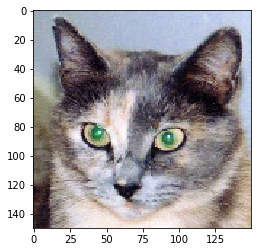

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img_tensor[0])
plt.show()

살펴볼 피처맵을 추출하기 위해서 입력 이미지의 배치를 얻고, 컨볼류션 및 풀링 계층의 출력을 얻는 케라스 모델을 만들었다. 이를 위해서 케라스의 Model 클래스를 사용하는데 Model은 입력 텐서와 출력 텐서로 구성된다. Sequential과 유사하나 Sequential과 달리 Model은 복수의 출력 (리스트)를 허용한다.

In [6]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

입력 이미지를 전달하면 이 모델의 활성화 계층의 값을 리턴한다. 동시에 여러개의 입력 및 출력을 볼 수 있는데 여기서는 하나의 입력과 8개의 출력을 나타낸다. 각 출력은 각 활성화 계층을 나타낸다.

In [7]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

예를 들어 아래는 위의 고양이 이미지에 대해서 첫번 째 컨볼류션의 활성화를 나타낸다.

In [8]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


위 텐서의 내용은 148x148 크기이 피처맵을 나타내며 32개의 채널로 구성되어 있다. 여기서 4번째 채널의 내용을 보면 아래와 같다.

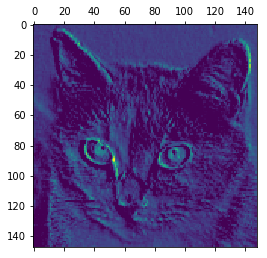

In [9]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')
plt.show()

이 채널은 아마도 대각선 방향의 에지 검출을 하는 것으로 보인다. 30번째 채널의 피처맵을 보면 아래와 같다. 피처맵은 정해진 의미를 갖는 것이 아니라 컴퓨터 실행에 따라 다르게 보일 수 있다 (학습을 랜덤하게 하므로). 

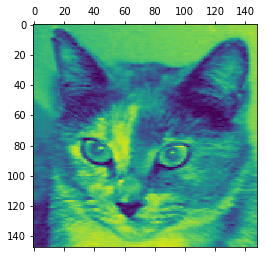

In [10]:
plt.matshow(first_layer_activation[0, :, :, 29], cmap='viridis')
plt.show()

이제 네트워크에 있는 모든 활성화 값을 그려보겠다. 8개의 활성화 맵에 대해서 32개 각 채널의 피처맵을 그리면 아래와 같다.

/Users/hjkim/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


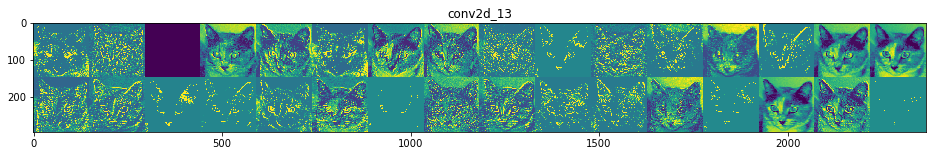

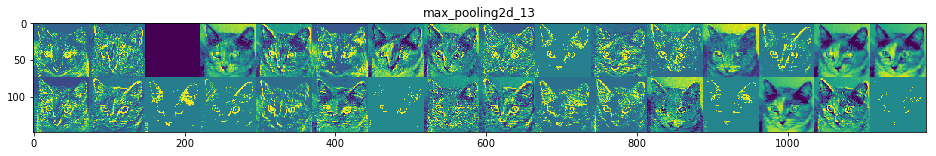

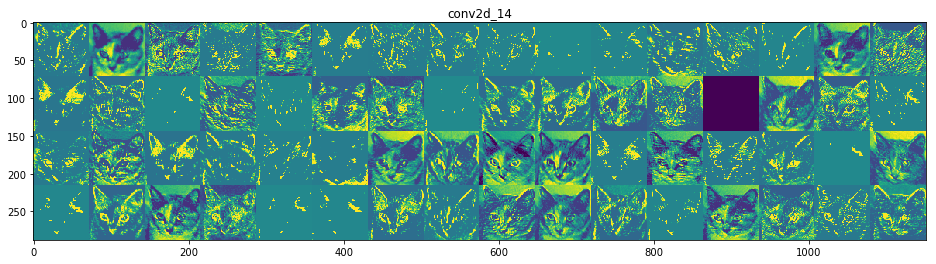

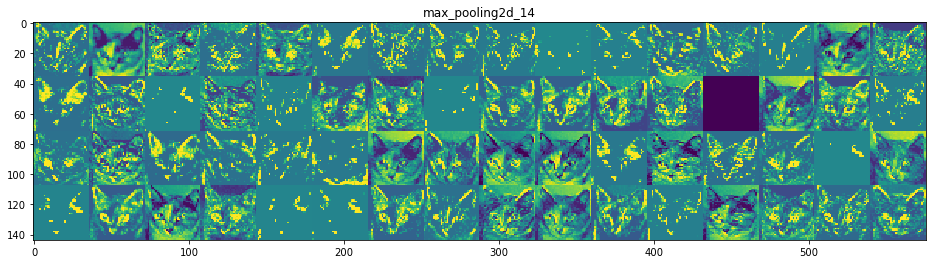

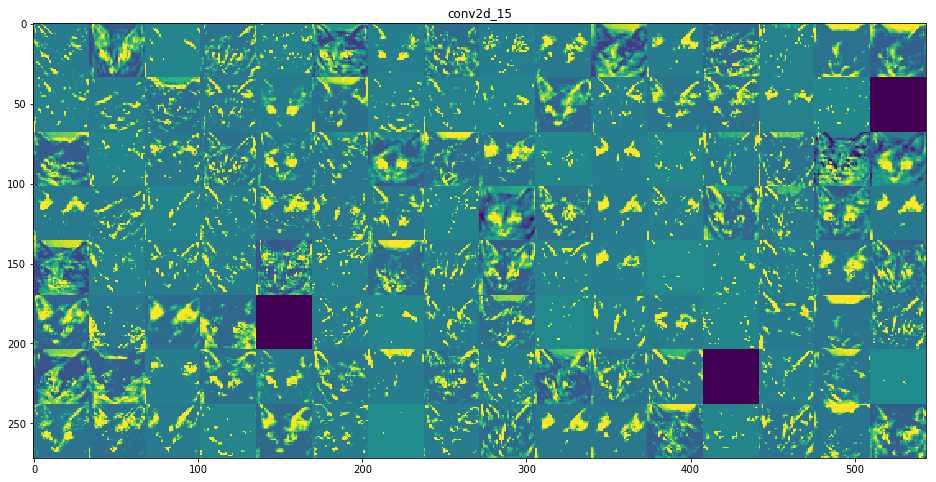

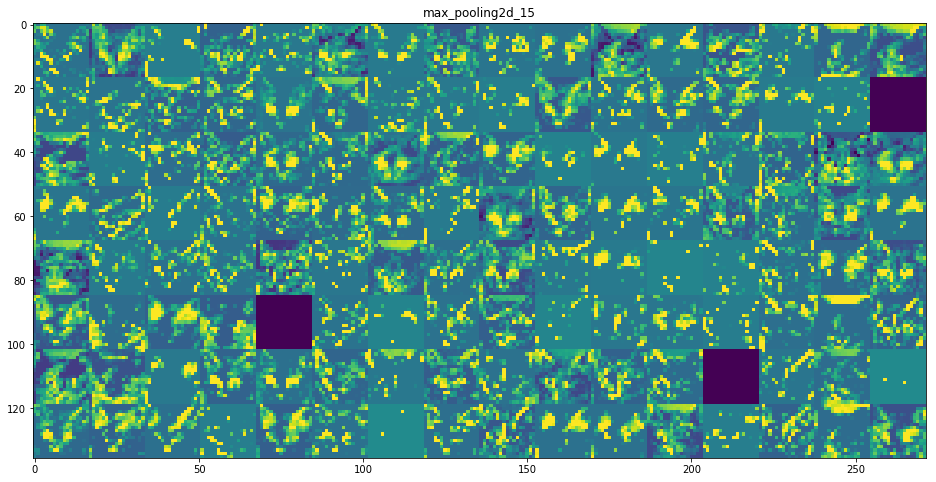

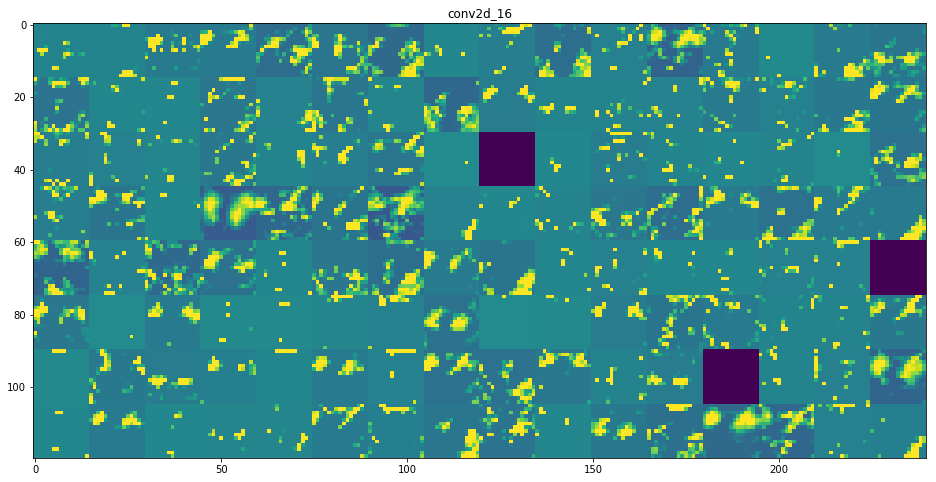

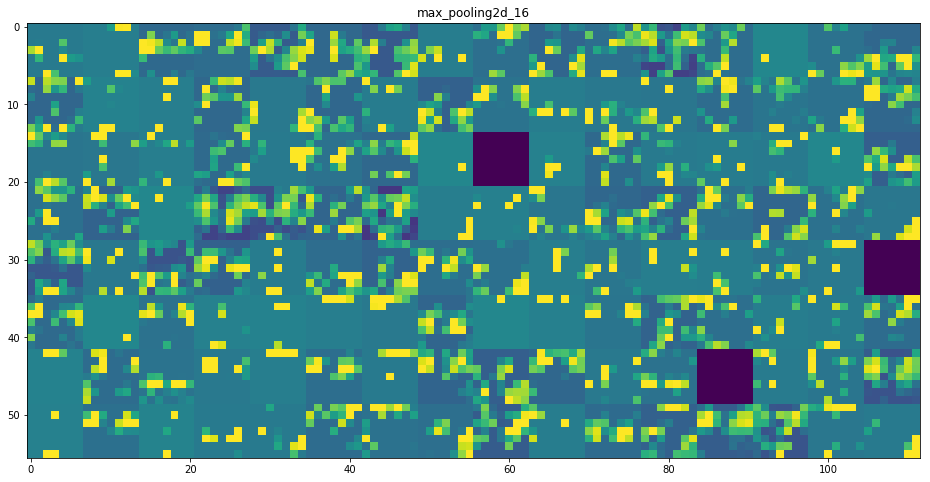

In [11]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

주요 사항은 다음과 같다.

- 첫번째 계층은 여러가지 엣지 검출기의 역할을 한다. 활성화 결과는 아직 이미지 자체의 형태 정보를 많이 포하하고 있다.

- 상위계층으로 갈수록 활성화 결과는 추상적인 형태를 가지고, 그림의 의미를 설명하기 어려운 모양을 나타낸다. 이제 고양이귀, 고양이 눈 등의 개념을 엔코딩하게 된다. 상위계층으로 갈수록 시각적인 형태 정보를 잃고 이미지의 클래스와 관련된 정보를 담게 된다.

- 계층을 올라갈수록 필터의 계수가 없는 경우가 자주 발생한다. 낮은 계층에서는 모든 필터가 동작을 하지만 고층으로 갈수록 출력이 없는 필터가 발생하는 빈도가 높아진다. 즉, 이 필터에 의해 추출되는 정보가 입력단에서 발견되지 않는다는 뜻이다.

이러한 현상은 딥러닝에서 계층이 깊어질수롤 점차 추상적인  정보를 다루는 것이라고 하겠다. 이를 information distillation pipeline 이라고 부른다.

## cnn 필터의 시각화

각 필터의 특성을 시각화 해보는 것이다. 손실함수를 정의하여 주어진 필터의 값을 최대화 하도록 SGD 알고리즘을 적용한다. 예를 들어 이미지넷으로 사전학습한 VGG16 네트워크의 block3_conv1 계층의 손실함수를 그렸다.

In [16]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

경사강하를 구하기 위해서 이 손실함수의 기울기를 구해야 한다 (모델 입력에 대한). 이를 위해서 케라스의 backend 모듈이 제공하는 gradients 함수를 사용한다.

In [17]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

경사강하를 원만하게 계산하기 위해서 경사 텐서값을 L2 놈으로 정규화하는 것이 좋다. 이렇게 하면 입력 이미지의 업데이트 크기를 일정한 범위 내로 제한할 수 있다.

In [18]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

주어진 입력 이미지에 대해서 이제 손실 텐서와 경사 텐서를 계산해야 한다. 이를 위해서 케라스의 backend가 제공하는 iterate 함수를 사용하는데, 이는 Numpy 텐서를 받아서 두개의 Numpy 텐서, 손신값과 경사값을 리턴한다.

In [19]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

이제 SGD를 계산하기 위해서 파이선 루프를 사용한다.

In [20]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

결과 이미지 텐서는 부동소수 값을 갖는 (1, 150, 150, 3) 구조이다. 즉, 값이 정수가 아니다. 이를 화면에 보기좋게 하기 위해서 아래와 같은 유틸리티 함수를 사용한다.

In [21]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

이제 모든 준비가 되었고, 특정 필터를 활성화 하는데 가장 많은 영향을 주는 이미지 패턴을 그려보겠다.

In [22]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

Let's try this:

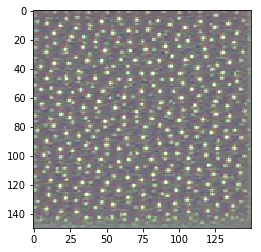

In [23]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

위 그림을 보면 계층 block3_conv1의 필터0은 폴카 점 패턴에 반응하는 것을 알 수 있다.

이제 각 계층의 필터를 시각화 해보겠다. 우선 각 계층의 앞 부분 64개의 필터를 보겠다. 64x64 크기의 필터 패턴을 8x8 그리드로 나타냈다.

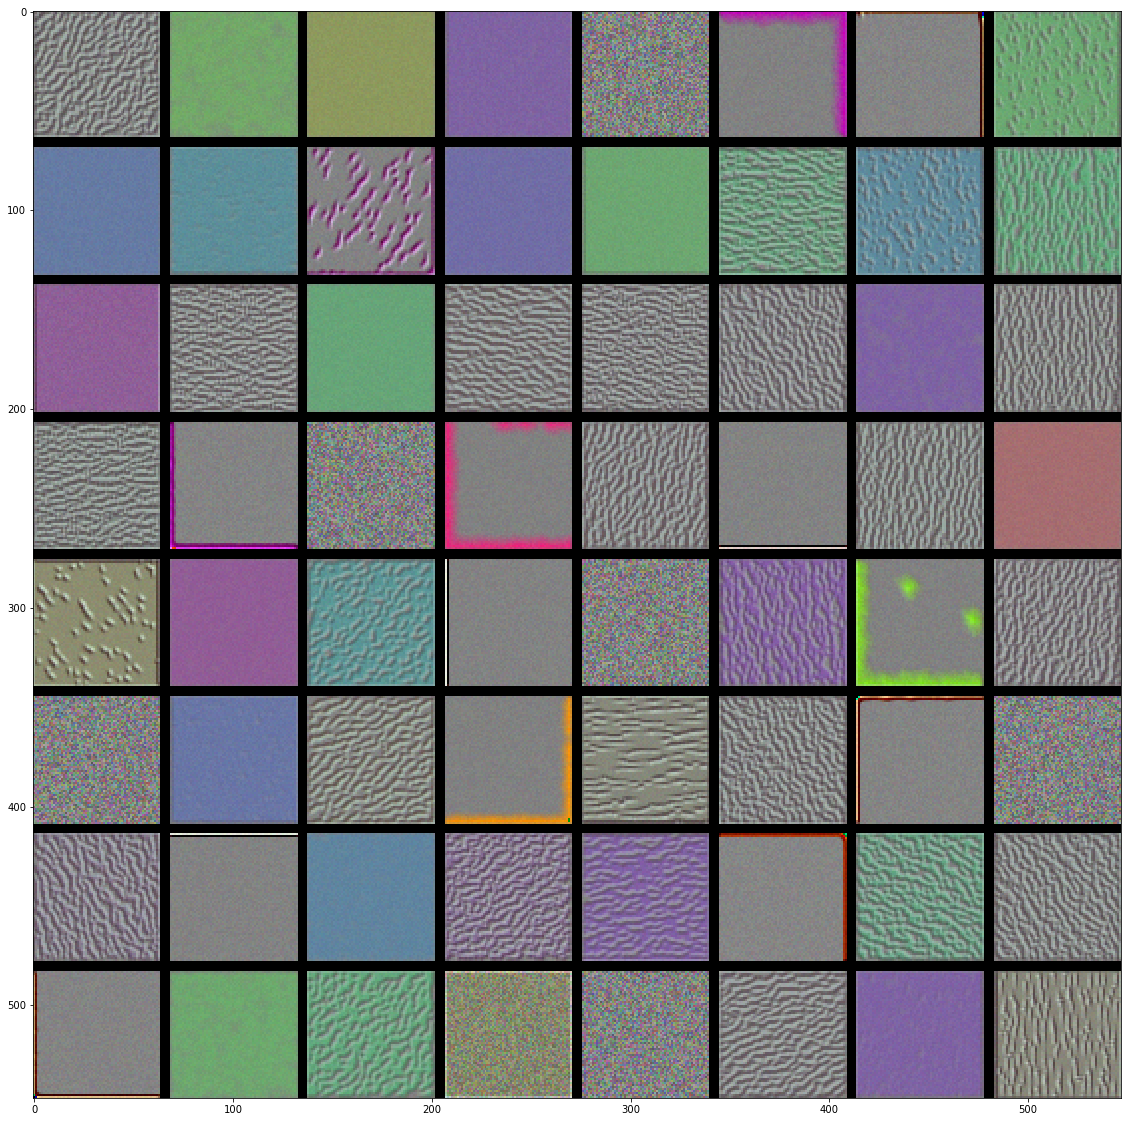

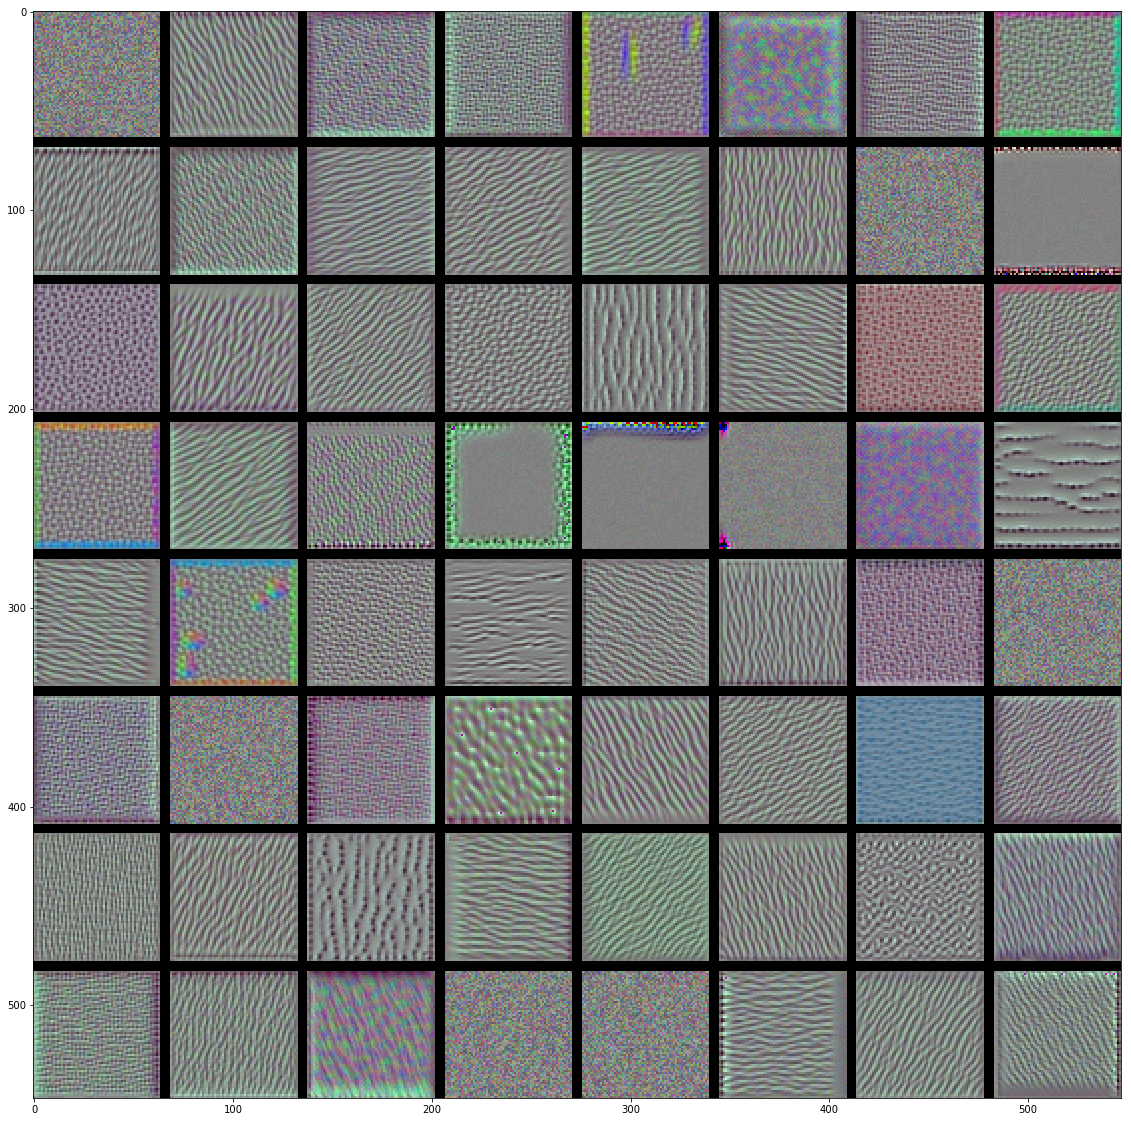

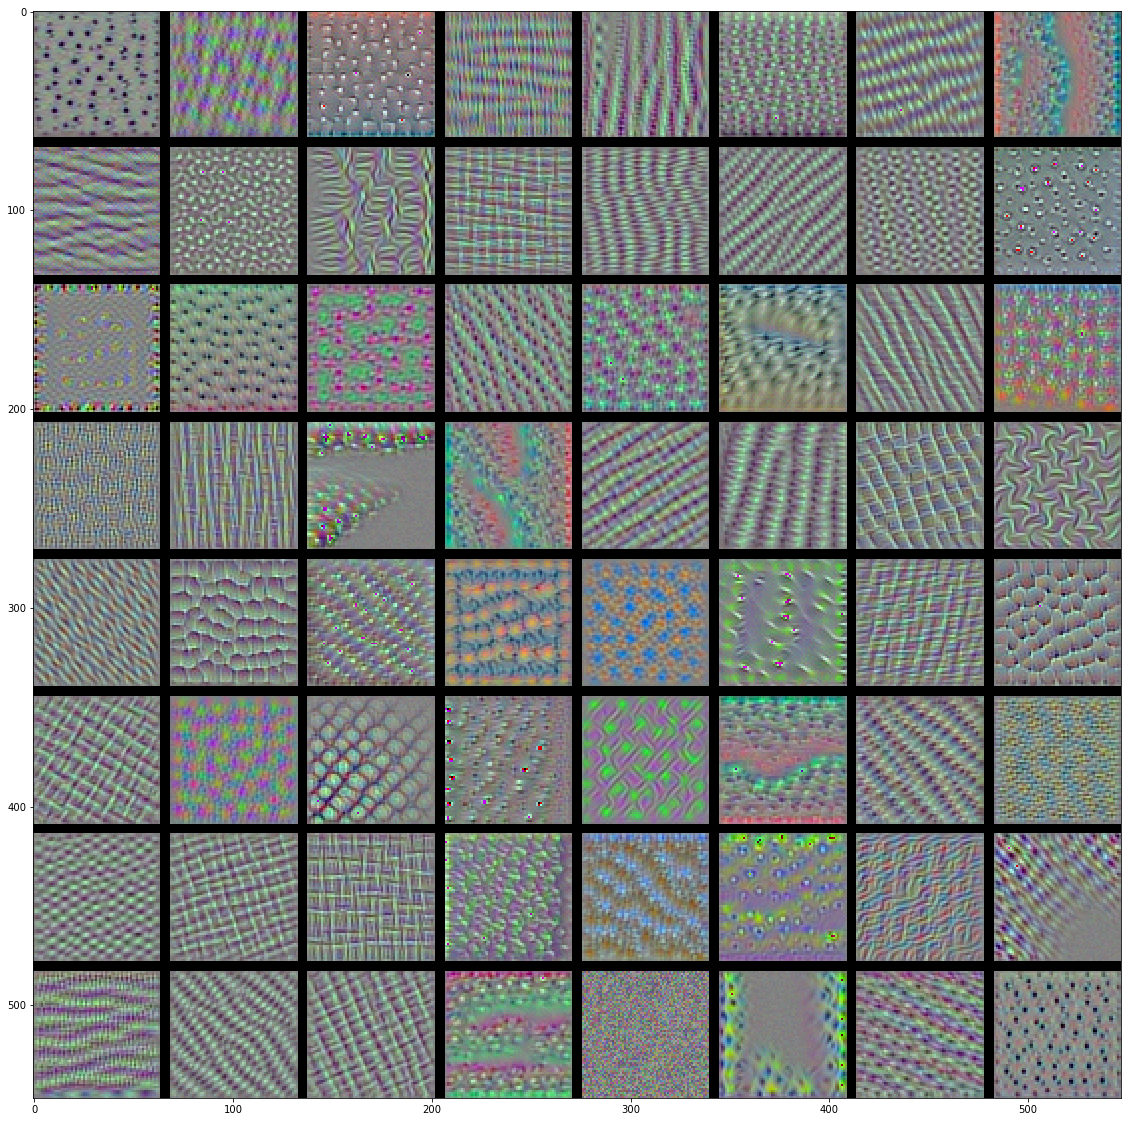

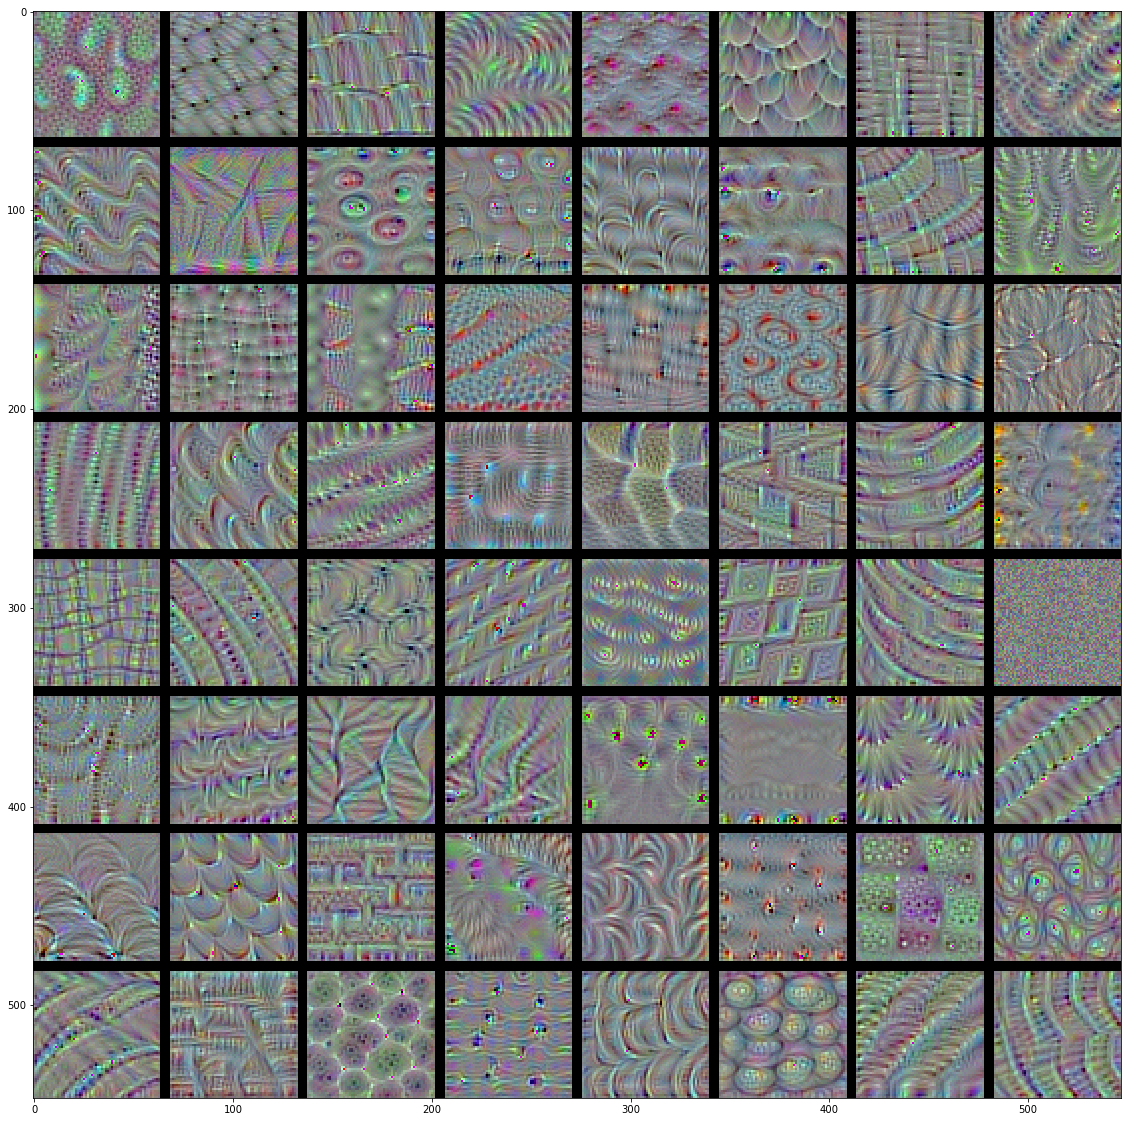

In [24]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

이제 각 cnn 계층이 세상을 어떻게 바라보는지를 알 수 있다. 각 필터는 마치 푸리에 트랜스폼이 신호를 코사인 함수들의 집합으로 변환하는 것과 같은 효과를 준다.  
in the model:

* The filters from the first layer in the model (`block1_conv1`) encode simple **directional edges and colors** (or colored edges in some 
cases).
* The filters from `block2_conv1` encode simple textures made from combinations of edges and colors.
* The filters in higher-up layers start resembling textures found in natural images: **feathers, eyes, leaves, etc**.

## Visualizing heatmaps of class activation

We will introduce one more visualization technique, one that is useful for understanding which parts of a given image led a convnet to its 
final classification decision. This is helpful for "debugging" the decision process of a convnet, in particular in case of a classification 
mistake. It also allows you to locate specific objects in an image.

This general category of techniques is called "Class Activation Map" (CAM) visualization, and consists in producing heatmaps of "class 
activation" over input images. A "class activation" heatmap is a 2D grid of scores associated with an specific output class, computed for 
every location in any input image, indicating how important each location is with respect to the class considered. For instance, given a 
image fed into one of our "cat vs. dog" convnet, Class Activation Map visualization allows us to generate a heatmap for the class "cat", 
indicating how cat-like different parts of the image are, and likewise for the class "dog", indicating how dog-like differents parts of the 
image are.

The specific implementation we will use is the one described in [Grad-CAM: Why did you say that? Visual Explanations from Deep Networks via 
Gradient-based Localization](https://arxiv.org/abs/1610.02391). It is very simple: it consists in taking the output feature map of a 
convolution layer given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the 
channel. Intuitively, one way to understand this trick is that we are weighting a spatial map of "how intensely the input image activates 
different channels" by "how important each channel is with regard to the class", resulting in a spatial map of "how intensely the input 
image activates the class".

We will demonstrate this technique using the pre-trained VGG16 network again:

In [ ]:
from keras.applications.vgg16 import VGG16

K.clear_session()

# Note that we are including the densely-connected classifier on top;
# all previous times, we were discarding it.
model = VGG16(weights='imagenet')

  4497408/553467096 [..............................] - ETA: 7:31:55

Let's consider the following image of two African elephants, possible a mother and its cub, strolling in the savanna (under a Creative 
Commons license):

![elephants](https://s3.amazonaws.com/book.keras.io/img/ch5/creative_commons_elephant.jpg)

Let's convert this image into something the VGG16 model can read: the model was trained on images of size 224x244, preprocessed according 
to a few rules that are packaged in the utility function `keras.applications.vgg16.preprocess_input`. So we need to load the image, resize 
it to 224x224, convert it to a Numpy float32 tensor, and apply these pre-processing rules.

In [27]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# The local path to our target image
img_path = '/Users/fchollet/Downloads/creative_commons_elephant.jpg'

# `img` is a PIL image of size 224x224
img = image.load_img(img_path, target_size=(224, 224))

# `x` is a float32 Numpy array of shape (224, 224, 3)
x = image.img_to_array(img)

# We add a dimension to transform our array into a "batch"
# of size (1, 224, 224, 3)
x = np.expand_dims(x, axis=0)

# Finally we preprocess the batch
# (this does channel-wise color normalization)
x = preprocess_input(x)

In [29]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.90942144), ('n01871265', 'tusker', 0.08618243), ('n02504013', 'Indian_elephant', 0.0043545929)]



The top-3 classes predicted for this image are:

* African elephant (with 92.5% probability)
* Tusker (with 7% probability)
* Indian elephant (with 0.4% probability)

Thus our network has recognized our image as containing an undetermined quantity of African elephants. The entry in the prediction vector 
that was maximally activated is the one corresponding to the "African elephant" class, at index 386:

In [30]:
np.argmax(preds[0])

386

To visualize which parts of our image were the most "African elephant"-like, let's set up the Grad-CAM process:

In [31]:
# This is the "african elephant" entry in the prediction vector
african_elephant_output = model.output[:, 386]

# The is the output feature map of the `block5_conv3` layer,
# the last convolutional layer in VGG16
last_conv_layer = model.get_layer('block5_conv3')

# This is the gradient of the "african elephant" class with regard to
# the output feature map of `block5_conv3`
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# This is a vector of shape (512,), where each entry
# is the mean intensity of the gradient over a specific feature map channel
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# This function allows us to access the values of the quantities we just defined:
# `pooled_grads` and the output feature map of `block5_conv3`,
# given a sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# These are the values of these two quantities, as Numpy arrays,
# given our sample image of two elephants
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature map array
# by "how important this channel is" with regard to the elephant class
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# The channel-wise mean of the resulting feature map
# is our heatmap of class activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

For visualization purpose, we will also normalize the heatmap between 0 and 1:

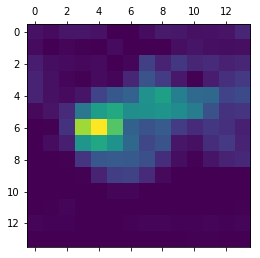

In [32]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

Finally, we will use OpenCV to generate an image that superimposes the original image with the heatmap we just obtained:

In [ ]:
import cv2

# We use cv2 to load the original image
img = cv2.imread(img_path)

# We resize the heatmap to have the same size as the original image
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)

# We apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4 here is a heatmap intensity factor
superimposed_img = heatmap * 0.4 + img

# Save the image to disk
cv2.imwrite('/Users/fchollet/Downloads/elephant_cam.jpg', superimposed_img)

![elephant cam](https://s3.amazonaws.com/book.keras.io/img/ch5/elephant_cam.jpg)

This visualisation technique answers two important questions:

* Why did the network think this image contained an African elephant?
* Where is the African elephant located in the picture?

In particular, it is interesting to note that the ears of the elephant cub are strongly activated: this is probably how the network can 
tell the difference between African and Indian elephants.
